In [1]:
from config.paths import * 
from config.parameters import emb_dim as dim 

from helper.paths import *
from helper.tuning import *
from helper.annotations import *
from helper.dataframes import *
from helper.lib_SA import visualizeSA
from helper.lib_faiss import *
from helper.common_libraries import join, np,plt

p = 5
plt.rcParams['figure.figsize'] = [p,p]

In [2]:
channel = 'XX00001'
points = '8'

path_dir_masks_xb = join(path_root_masks_from_images,points,channel)
path_dir_emb_xb = join(path_root_embeddings_from_masks,points,channel,'df_merged')
path_list_emb_xb = collectPaths(path_dir_emb_xb)

path_dir_masks_xq = join(path_root_manual_annotation,channel,'ann_images')
path_dir_emb_xq = join(path_root_manual_annotation,channel,'df_merged')
path_list_emb_xq = collectPaths(path_dir_emb_xq)

cat = 90001
df_xq = stackDf([filterCat(readDf(path),cat) for path in path_list_emb_xq])
df_xq

,timestamp_id,SA_id,is_head,solo,head_id,area_segm,height,width,area_bbox,AoI,...,758,759,760,761,762,763,764,765,766,767
5,XX00001_20230318_000113,0,1,1,0,105133,415,356,147740,1,...,-0.02618,-0.1029,0.2570,-0.47100,0.26980,0.2094,0.10944,0.3315,-0.295700,0.1744
6,XX00001_20230318_000155,0,1,1,0,79497,316,380,120080,1,...,0.15100,-0.2335,-0.3130,-0.17300,-0.07886,0.4710,-0.09174,-0.1270,0.001467,-0.1583
8,XX00001_20230318_000183,0,1,1,0,79859,348,292,101616,1,...,0.22560,-0.5195,0.2097,0.13940,-0.01293,0.4167,0.09510,-0.0931,-0.076660,-0.3516
9,XX00001_20230318_000265,0,1,1,0,61726,295,231,68145,1,...,-0.22300,-0.4463,0.1406,0.05908,0.02469,0.2678,-0.28760,-0.4207,0.137000,-0.3552
10,XX00001_20230318_000300,0,1,1,0,61982,280,327,91560,1,...,-0.13130,-0.4888,0.1480,-0.16100,0.16690,-0.2218,0.28930,-0.2686,-0.077200,-0.4622


In [3]:
index = initFaissIndex()
timestamp_ids = []
SA_ids = []

for path in path_list_emb_xb:
    df = readDf(path)
    df = filterAoI(df,1)
    df = filterHead(df,1)
    index,timestamp_ids,SA_ids = addFaissIndex(index,df,timestamp_ids,SA_ids)


In [ ]:
path_dir_emb_merged = join(path_root_manual_annotation,channel,'df_merged')
path_list_emb_merged = collectPaths(path_dir_emb_merged)


df_xb = readDf(path_list_emb_merged[0])
df_xq = readDf(path_list_emb_merged[0])

df_xb
df_xq = df_xq[df_xq['category_id']==90001][:5]

df_xb.loc[df_xq.index,:]

In [12]:
cat = '11'

path_xq = [path for path in collectPaths(path_root_embeddings_xq) if cat in getName(path)][0]
df_xq = readDf(path_xq)
xq = np.array(df_xq.iloc[:,-dim:],dtype='float16',order='C')

df_area_q = df_xq[['area_segm']]

ql = .2
qh = .8
min_area = df_area_q.quantile([ql,qh]).iloc[0,0]
max_area = df_area_q.quantile([ql,qh]).iloc[1,0]

df_area_q.describe(),min_area,max_area

(           area_segm
 count       3.000000
 mean   470945.000000
 std    398933.461004
 min    208640.000000
 25%    241398.500000
 50%    274157.000000
 75%    602097.500000
 max    930038.000000,
 234846.8,
 667685.6000000001)

In [13]:
path_xb = collectPaths(path_root_embeddings_xb)[0]
df_xb = readDf(path_xb)
df_xb = df_xb[np.logical_and(min_area<=df_xb['area_segm'], df_xb['area_segm']<=max_area)]
xb = np.array(df_xb.iloc[:,-dim:],dtype='float32',order='C')

In [14]:
index = faiss.IndexFlatL2(dim)
print(index.is_trained)
index.add(xb)
print(index.ntotal)

True
888


QUERY


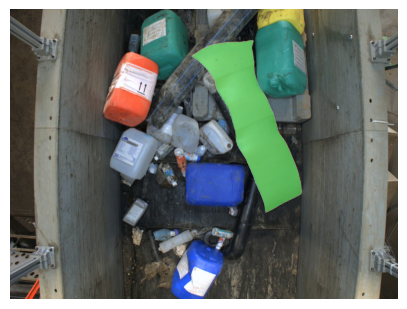

RETRIEVAL


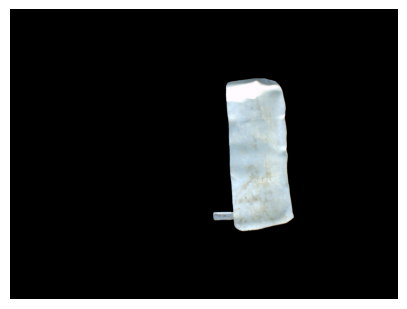

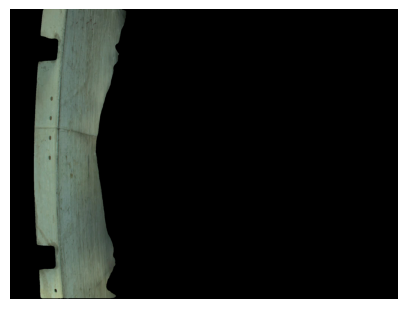

QUERY


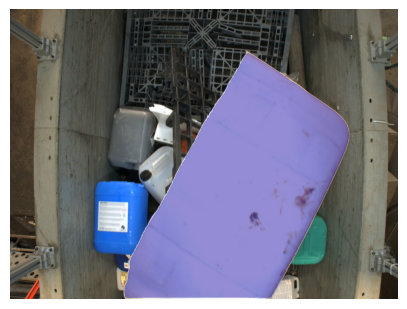

RETRIEVAL


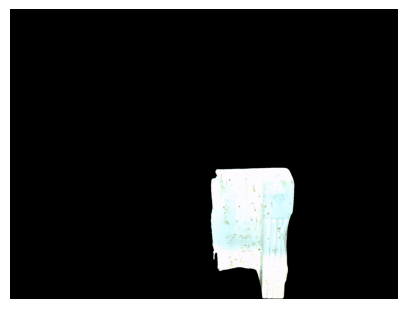

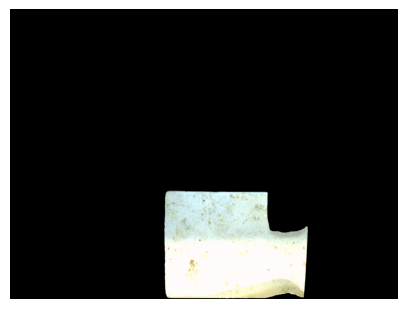

QUERY


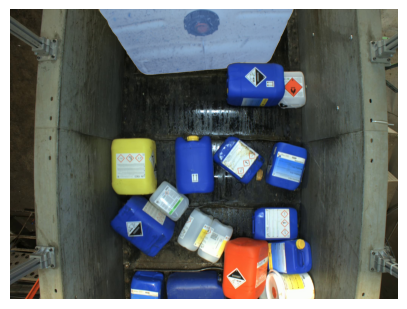

RETRIEVAL


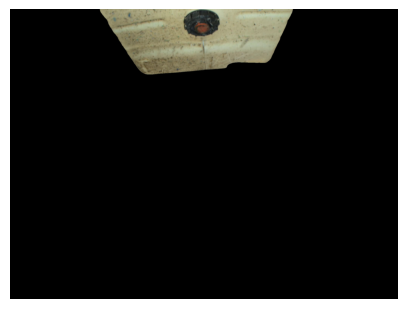

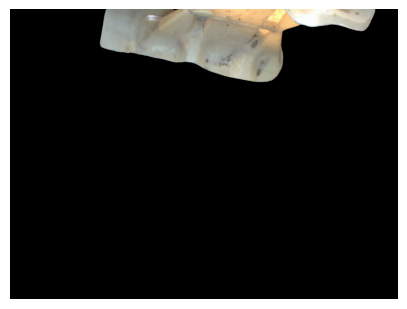

In [15]:
ids = lambda df,row_idx: df.iloc[row_idx,:][['timestamp_id','SA_id']]

k = 2
D, I = index.search(xq, k)

for xq_id,xb_ids in enumerate(I):
    print('QUERY')
    ids_xq = ids(df_xq,xq_id)
    tmstp = ids_xq[0]
    image = imreadRGB(getImagePath(tmstp))
    mask = decodeMasks(readJson([path for path in path_list_masks_xq if ids_xq[0] in path][0]))[ids_xq[1]]
    visualizeSA(image,mask)
    print('RETRIEVAL')
    for xb_id in xb_ids:
        ids_xb = ids(df_xb,xb_id)
        tmstp = ids_xb[0]
        image = imreadRGB(getImagePath(tmstp))
        mask = decodeMasks(readJson(getMasksPath(ids_xb[0],sampling_pts_coarse)))[ids_xb[1]]
        visualizeOnly(image,mask)

## POC

In [ ]:
taxonomy, text_prompt_categories, names_all, names_subparts = getTaxonomy(channel)§
names_all

['bottle cap',
 'label',
 'lid',
 'cistern',
 'drum',
 'jerrycan',
 'bucket',
 'bottle',
 'HDPE pipe',
 'plastic tubing',
 'plastic pallet',
 'bottle crate',
 'plastic basket',
 'waste container',
 'blur']

In [ ]:
cat = 4
thresh = .5

df_jerry = all[np.logical_and(all['cat']==cat,all['score']>=thresh)]
xq = np.array(df_jerry.iloc[:,-768:],dtype='float32',order='C')
print(len(xq))

df_else = all[np.logical_or(all['cat']!=cat,all['score']<thresh)]
xb = np.array(df_else.iloc[:,-768:],dtype='float32',order='C')

292


In [ ]:
id_drum = 'XX00001_20230318_000020'
id_cistern = 'XX00001_20230318_000185'
id_ = id_cistern

image = imreadRGB(getImagePath(id_))

path_file_masks = getMasksPath(id_,sampling_pts_fine,sub=True)
masks = decodeMasks(readJson(path_file_masks))

if False:
    for mask in masks:
        print(mask['id'])
        visualizeOnly(image,mask)
    
idx = 0

In [ ]:
df_jerry = all[np.logical_and(all['image_name']==id_+'.jpg',all['SA_id']==idx)]
xq = np.array(df_jerry.iloc[:,-768:],dtype='float32',order='C')

df_else =  all[np.logical_or(all['image_name']!=id_+'.jpg',all['SA_id']!=idx)]
xb = np.array(df_else.iloc[:,-768:],dtype='float32',order='C')

In [ ]:
df_jerry

,image_name,SA_id,area_segm,height,width,area_bbox,cat,score,0,1,...,758,759,760,761,762,763,764,765,766,767
0,XX00001_20230318_000185.jpg,0,703835,931,1016,945896,10,0.837891,-0.959,-0.1124,...,-0.393,0.03943,0.05118,-0.02657,0.3118,-0.1737,0.4707,0.12384,0.2827,-0.477


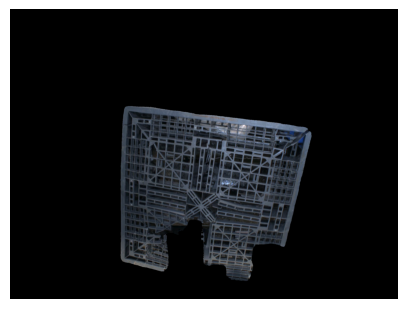

In [ ]:
image_name_q = df_jerry.iloc[0]['image_name']
mask_id_q = df_jerry.iloc[0]['SA_id']

image_q = imreadRGB(getImagePath(getId(image_name_q)))
mask_q = decodeMasks(readJson(getMasksPath(getId(image_name_q),sampling_pts_fine,sub=True)))[mask_id_q]
visualizeOnly(image_q,mask_q)

In [ ]:
index = faiss.Inde

In [ ]:
k = 10                          # we want to see 4 nearest neighbors
D, I = index.search(xq, k) # sanity check
print(D)
print(I)

[[ 60.961155  75.30283   83.15405   84.93684   87.35747   92.89969
   97.119995  98.96146  104.501045 104.86968 ]]
[[11910  8901  9907 11958  6665 10118 10193  6529  6586  8445]]


0


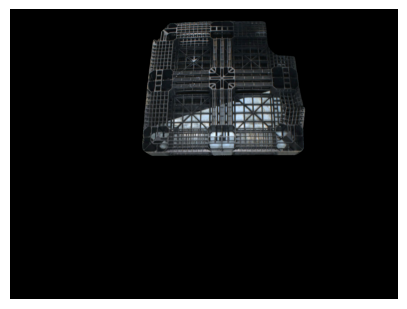

0


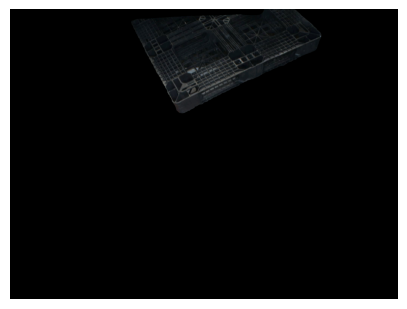

0


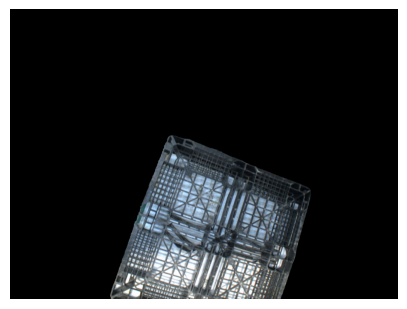

0


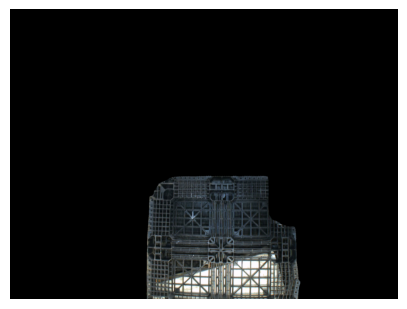

0


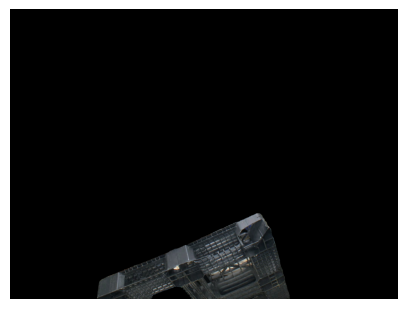

1


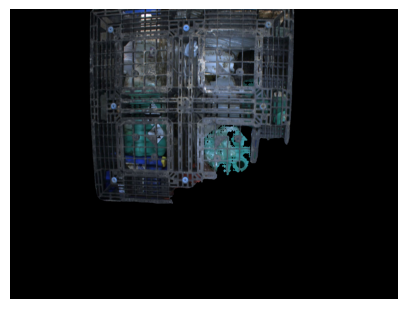

0


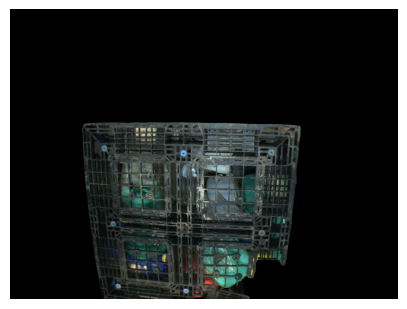

0


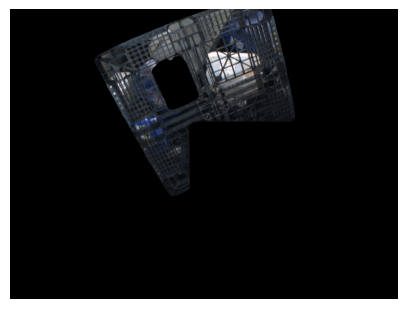

1


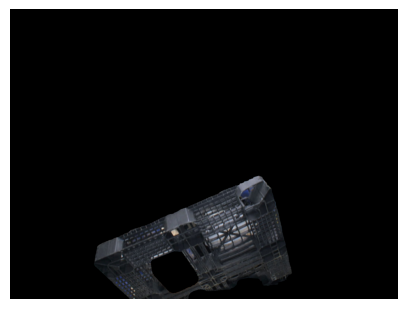

12


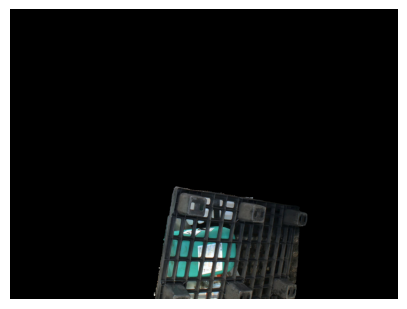

In [ ]:
I = I.squeeze()
best_matches = I
for count in best_matches:
    image_name = df_else.iloc[count]['image_name']
    mask_id = df_else.iloc[count]['SA_id']
    print(mask_id)

    image_q = imreadRGB(getImagePath(getId(image_name)))
    mask_q = decodeMasks(readJson(getMasksPath(getId(image_name),sampling_pts_fine,sub=True)))[mask_id]
    visualizeOnly(image_q,mask_q)

In [ ]:
query_idx

array([    0,     1, 24677, 21132])

In [ ]:
D, I = index.search(xq, k)     # actual search
print(I[:5])                   # neighbors of the 5 first queries
print(I[-5:])                  # neighbors of the 5 last queries

[[21390 14744 23449 13822]
 [ 5552 25887 12547  5311]
 [11360 11314  7295 16171]
 [  794 11146  8240  7653]
 [ 1667  1942  6439 11432]]
[[ 2039  2641  2544 28291]
 [13469 27085 13432 29293]
 [28903  1842 28735 25864]
 [ 2039 25864 10521  2030]
 [28819 28903  4666 26468]]


In [ ]:
d = 64                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(1234)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
xq[:, 0] += np.arange(nq) / 1000.